**<font size=4>Signal Smoothing</font>**

This example shows how to use moving average filters and resampling to isolate the effect of periodic components of the time of day on hourly temperature readings, as well as remove unwanted line noise from an open-loop voltage measurement. The example also shows how to smooth the levels of a clock signal while preserving the edges by using a median filter. The example also shows how to use a Hampel filter to remove large outliers.

**Motivation**

Smoothing is how we discover important patterns in our data while leaving out things that are unimportant (i.e. noise). We use filtering to perform this smoothing. The goal of smoothing is to produce slow changes in value so that it's easier to see trends in our data.

Sometimes when you examine input data you may wish to smooth the data in order to see a trend in the signal. In our example we have a set of temperature readings in Celsius taken every hour at Logan Airport for the entire month of January, 2011.

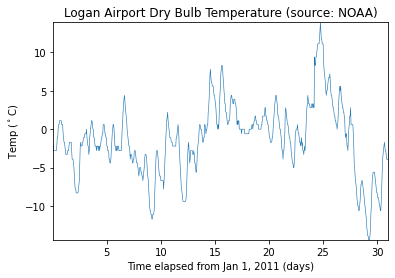

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

tempC = loadmat("bostemp.mat")
days = (np.arange(31*24)+1)/24
fig,ax = plt.subplots();ax.plot(days,tempC['tempC'],linewidth=0.6)
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

Note that we can visually see the effect that the time of day has upon the temperature readings. If you are only interested in the daily temperature variation over the month, the hourly fluctuations only contribute noise, which can make the daily variations difficult to discern. To remove the effect of the time of day, we would now like to smooth our data by using a moving average filter.

**A Moving Average Filter**

In its simplest form, a moving average filter of length N takes the average of every N consecutive samples of the waveform.

To apply a moving average filter to each data point, we construct our coefficients of our filter so that each point is equally weighted and contributes 1/24 to the total average. This gives us the average temperature over each 24 hour period.

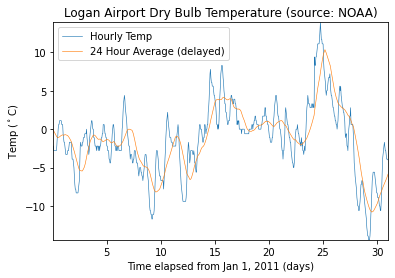

In [2]:
from scipy import signal
hoursPerDay = 24
coeff24hMA = np.ones(hoursPerDay)/hoursPerDay
zi = signal.lfilter_zi(coeff24hMA,1)*0
avg24hTempC,_ = signal.lfilter(coeff24hMA,1,tempC['tempC'].flatten(),zi=zi)
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days,avg24hTempC,linewidth=0.6,label='24 Hour Average (delayed)')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

**Filter Delay**

Note that the filtered output is delayed by about twelve hours. This is due to the fact that our moving average filter has a delay.

Any symmetric filter of length N will have a delay of (N-1)/2 samples. We can account for this delay manually.

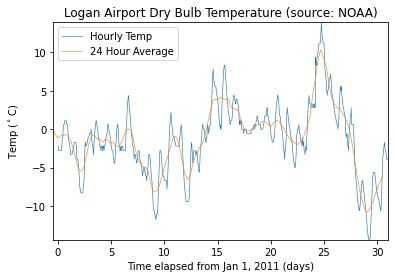

In [3]:
fDelay = (coeff24hMA.size-1)/2;
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days-fDelay/24,avg24hTempC,linewidth=0.6,label='24 Hour Average')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

**Extracting Average Differences**

Alternatively, we can also use the moving average filter to obtain a better estimate of how the time of day affects the overall temperature. To do this, first, subtract the smoothed data from the hourly temperature measurements. Then, segment the differenced data into days and take the average over all 31 days in the month.

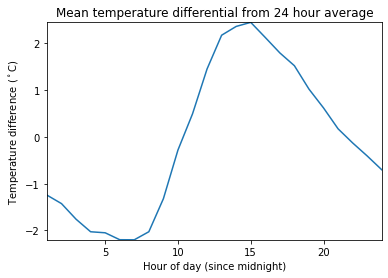

In [4]:
deltaTempC = tempC['tempC'].flatten() - avg24hTempC;
fig,ax = plt.subplots()
ax.plot(np.arange(24)+1,np.mean(deltaTempC.reshape(31,24),0))
ax.set_title('Mean temperature differential from 24 hour average')
ax.set_xlabel('Hour of day (since midnight)')
ax.set_ylabel('Temperature difference ($ ^\circ $C)')
ax.autoscale(tight=True)

**Extracting Peak Envelope**

Sometimes we would also like to have a smoothly varying estimate of how the highs and lows of our temperature signal change daily. To do this we can use the envelope function to connect extreme highs and lows detected over a subset of the 24 hour period. In this example, we ensure there are at least 16 hours between each extreme high and extreme low. We can also get a sense of how the highs and lows are trending by taking the average between the two extremes.

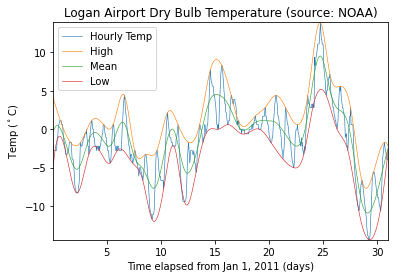

In [5]:
from scipy import interpolate
envHigh_index,_ = signal.find_peaks(tempC['tempC'].flatten(),distance=16)
envHigh = (interpolate.UnivariateSpline(days[envHigh_index],
         tempC['tempC'][envHigh_index].flatten(),s=0))
envLow_index,_ = signal.find_peaks(-tempC['tempC'].flatten(),distance=16)
envLow = (interpolate.UnivariateSpline(days[envLow_index],
         tempC['tempC'][envLow_index].flatten(),s=0))
envMean = (envHigh(days)+envLow(days))/2;
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days,envHigh(days),linewidth=0.6,label='High')
ax.plot(days,envMean,linewidth=0.6,label='Mean')
ax.plot(days,envLow(days),linewidth=0.6,label='Low')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

**Weighted Moving Average Filters**

Other kinds of moving average filters do not weight each sample equally.

Another common filter follows the binomial expansion of $[1/2,1/2]^n$. This type of filter approximates a normal curve for large values of n. It is useful for filtering out high frequency noise for small n. To find the coefficients for the binomial filter, convolve $[1/2,1/2]$ with itself and then iteratively convolve the output with $[1/2,1/2]$ a prescribed number of times. In this example, use five total iterations.

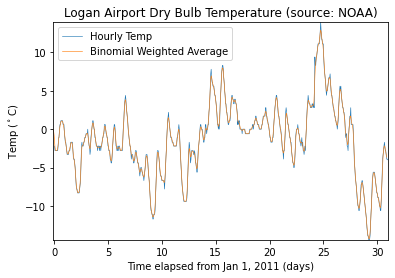

In [6]:
h = np.array([1/2,1/2])
binomialCoeff = signal.convolve(h,h)
for n in range(4):
    binomialCoeff = signal.convolve(binomialCoeff,h)
fDelay = (len(binomialCoeff)-1)/2
zi = signal.lfilter_zi(binomialCoeff,1)*0
binomialMA,_ = signal.lfilter(binomialCoeff,1,tempC['tempC'].flatten(),zi=zi)
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days-fDelay/24,binomialMA,linewidth=0.6,label='Binomial Weighted Average')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

Another filter somewhat similar to the Gaussian expansion filter is the exponential moving average filter. This type of weighted moving average filter is easy to construct and does not require a large window size.

You adjust an exponentially weighted moving average filter by an alpha parameter between zero and one. A higher value of alpha will have less smoothing.

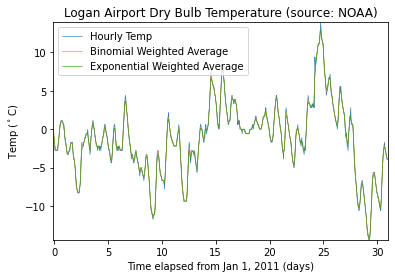

In [7]:
alpha = 0.45
zi = signal.lfilter_zi(np.array([alpha]),np.array([1,alpha-1]))*0
exponentialMA,_ = (signal.lfilter(np.array([alpha]),np.array([1,alpha-1]),
                   tempC['tempC'].flatten(),zi=zi))
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days-fDelay/24,binomialMA,linewidth=0.6,label='Binomial Weighted Average')
ax.plot(days-1/24,exponentialMA,linewidth=0.6,label='Exponential Weighted Average')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)

Zoom in on the readings for one day.

(-5.0, 2.0)

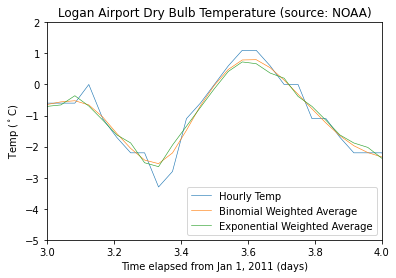

In [9]:
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days-fDelay/24,binomialMA,linewidth=0.6,label='Binomial Weighted Average')
ax.plot(days-1/24,exponentialMA,linewidth=0.6,label='Exponential Weighted Average')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.set_xlim([3,4])
ax.set_ylim([-5,2])

**Savitzky-Golay Filters**

You'll note that by smoothing the data, the extreme values were somewhat clipped.

To track the signal a little more closely, you can use a weighted moving average filter that attempts to fit a polynomial of a specified order over a specified number of samples in a least-squares sense.

As a convenience, you can use the function sgolayfilt to implement a **Savitzky-Golay** smoothing filter. To use **sgolayfilt**, you specify an odd-length segment of the data and a polynomial order strictly less than the segment length. The **sgolayfilt** function internally computes the smoothing polynomial coefficients, performs delay alignment, and takes care of transient effects at the start and end of the data record.

(-5.0, 2.0)

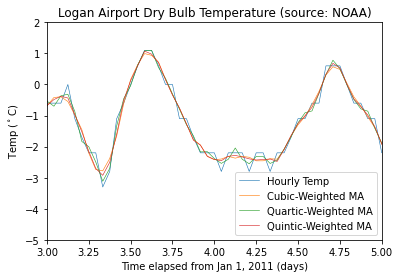

In [10]:
cubicMA = signal.savgol_filter(tempC['tempC'].flatten(),7,3)
quarticMA = signal.savgol_filter(tempC['tempC'].flatten(),7,4)
quinticMA = signal.savgol_filter(tempC['tempC'].flatten(),9,5)
fig,ax = plt.subplots()
ax.plot(days,tempC['tempC'],linewidth=0.6,label='Hourly Temp')
ax.plot(days,cubicMA,linewidth=0.6,label='Cubic-Weighted MA')
ax.plot(days,quarticMA,linewidth=0.6,label='Quartic-Weighted MA')
ax.plot(days,quinticMA,linewidth=0.6,label='Quintic-Weighted MA')
ax.legend()
ax.set_title('Logan Airport Dry Bulb Temperature (source: NOAA)')
ax.set_xlabel('Time elapsed from Jan 1, 2011 (days)')
ax.set_ylabel('Temp ($ ^\circ $C)')
ax.autoscale(tight=True)
ax.set_xlim([3,5])
ax.set_ylim([-5,2])

**Resampling**

Sometimes it is beneficial to resample a signal in order to properly apply a moving average.

In our next example, we sampled the open-loop voltage across the input of an analog instrument in the presence of interference from 60 Hz AC power line noise. We sampled the voltage with a 1 kHz sampling rate.

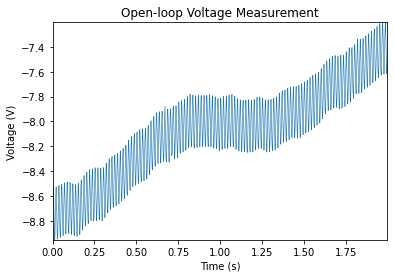

In [11]:
openLoopVoltage = loadmat("openloop60hertz.mat")
fs = 1000
t = np.arange(openLoopVoltage['openLoopVoltage'].size)/fs
fig,ax = plt.subplots()
ax.plot(t,openLoopVoltage['openLoopVoltage'],linewidth=0.6)
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (s)')
ax.set_title('Open-loop Voltage Measurement')
ax.autoscale(tight=True)

Let's attempt to remove the effect of the line noise by using a moving average filter. 

If you construct a uniformly weighted moving average filter, it will remove any component that is periodic with respect to the duration of the filter.

There are roughly 1000 / 60 = 16.667 samples in a complete cycle of 60 Hz when sampled at 1000 Hz. Let's attempt to "round up" and use a 17-point filter. This will give us maximal filtering at a fundamental frequency of 1000 Hz / 17 = 58.82 Hz.

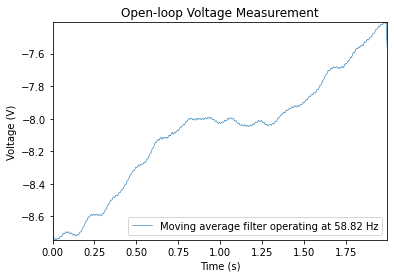

In [12]:
fig,ax = plt.subplots()
ax.plot(t,signal.savgol_filter(openLoopVoltage['openLoopVoltage'].flatten(),17,1),
        linewidth=0.6,label='Moving average filter operating at 58.82 Hz')
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (s)')
ax.set_title('Open-loop Voltage Measurement')
ax.legend(loc='lower right')
ax.autoscale(tight=True)

Note that while the voltage is significantly smoothed, it still contains a small 60 Hz ripple.

We can significantly reduce the ripple if we resample the signal so that we capture a complete full cycle of the 60 Hz signal by our moving average filter.

If we resample the signal at 17 * 60 Hz = 1020 Hz, we can use our 17 point moving average filter to remove the 60 Hz line noise.

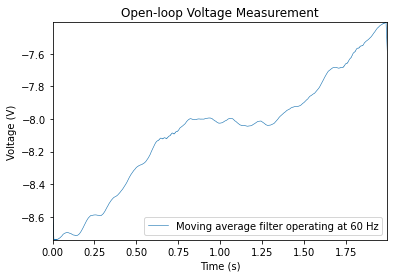

In [13]:
fsResamp = 1020
vResamp = signal.resample(openLoopVoltage['openLoopVoltage'].flatten(),
                          int(openLoopVoltage['openLoopVoltage'].size/fs*fsResamp))
tResamp = np.arange(vResamp.size)/fsResamp
vAvgResamp = signal.savgol_filter(vResamp,17,1)
fig,ax = plt.subplots()
ax.plot(tResamp,vAvgResamp,linewidth=0.6,label='Moving average filter operating at 60 Hz')
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (s)')
ax.set_title('Open-loop Voltage Measurement')
ax.legend(loc='lower right')
ax.autoscale(tight=True)

**Median Filter**

Moving average, weighted moving average, and Savitzky-Golay filters smooth all of the data they filter. This, however, may not always be what is wanted. For example, what if our data is taken from a clock signal and has sharp edges that we do not wish to smooth? The filters discussed so far do not work so well:

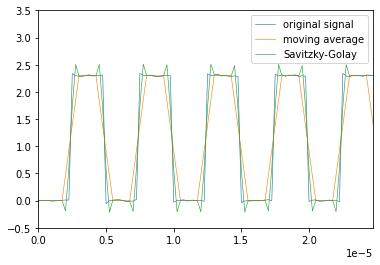

In [14]:
clock = loadmat('clockex.mat')
yMovingAverage = signal.convolve(clock['x'].flatten(),np.ones(5)/5,mode='same')
ySavitzkyGolay = signal.savgol_filter(clock['x'].flatten(),5,3)
fig,ax = plt.subplots()
ax.plot(clock['t'],clock['x'],linewidth=0.6,label='original signal')
ax.plot(clock['t'],yMovingAverage,linewidth=0.6,label='moving average')
ax.plot(clock['t'],ySavitzkyGolay,linewidth=0.6,label='Savitzky-Golay')
ax.set_ylim([-0.5,3.5])
ax.legend(loc='upper right')
ax.autoscale(enable=True, axis='x', tight=True)

The moving average and Savitzky-Golay filters respectively under-correct and over-correct near the edges of the clock signal.

A simple way to preserve the edges, but still smooth the levels is to use a median filter: 

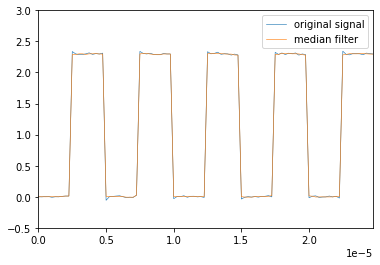

In [15]:
yMedFilt = signal.medfilt(clock['x'].flatten(),5)
fig,ax = plt.subplots()
ax.plot(clock['t'],clock['x'],linewidth=0.6,label='original signal')
ax.plot(clock['t'],yMedFilt,linewidth=0.6,label='median filter')
ax.set_ylim([-0.5,3])
ax.legend(loc='upper right')
ax.autoscale(enable=True, axis='x', tight=True)

**Outlier Removal via Hampel Filter**

Many filters are sensitive to outliers. A filter which is closely related to the median filter is the Hampel filter. This filter helps to remove outliers from a signal without overly smoothing the data.

To see this, load an audio recording of a train whistle and add some artificial noise spikes:

(0.0, 14000.0)

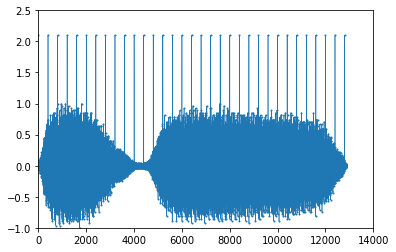

In [16]:
y = loadmat('train.mat')
y_addnoise = y['y'].flatten()
y_addnoise[::400] = 2.1
fig,ax = plt.subplots()
ax.scatter(np.arange(12880)+1,y_addnoise,s=1)
ax.plot(y_addnoise,linewidth=0.6,label='original signal')
ax.set_ylim([-1,2.5])
ax.set_xlim([0,14000])

Since each spike we introduced has a duration of just one sample, we can use a median filter of just three elements to remove the spikes.

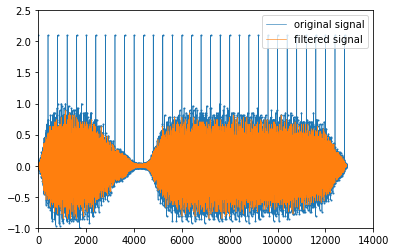

In [19]:
fig,ax = plt.subplots()
ax.scatter(np.arange(12880)+1,y_addnoise,s=1)
ax.plot(y_addnoise,linewidth=0.6,label='original signal')
ax.set_ylim([-1,2.5])
ax.set_xlim([0,14000])
ax.plot(signal.medfilt(y_addnoise,3),linewidth=0.6,label='filtered signal')
ax.legend()

The filter removed the spikes, but it also removed a large number of data points of the original signal. A Hampel filter works similar to a median filter, however it replaces just the values which are equivalent to a few standard deviations away from the local median value.

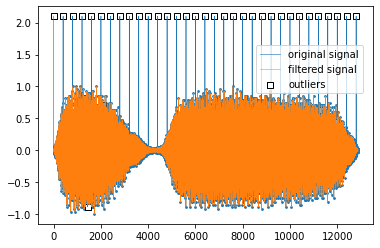

In [36]:
from hampel import hampel
import pandas as pd
y_an_series = pd.Series(y_addnoise.tolist())
y_addnoise_imp = hampel(y_an_series,window_size=11,imputation=True)
y_addnoise_out = hampel(y_an_series, window_size=11)
fig,ax = plt.subplots()
ax.plot(y_addnoise,linewidth=0.6,label='original signal')
ax.scatter(np.arange(12880)+1,y_addnoise,s=3)
ax.plot(y_addnoise_imp,linewidth=0.5,label='filtered signal')
ax.scatter(y_addnoise_out,y_addnoise[np.array(y_addnoise_out)],c='w',marker='s',edgecolors='black',label='outliers')
ax.legend(loc=(0.65,0.6))

Only the outliers are removed from the original signal.